In [1]:
%matplotlib inline
from cgcglib import *
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 10)

In [2]:
def plot_mesh(mesh):
    """Plot mesh with vertex coordinates."""
    plot(mesh)
    plt.axis('off')
    for (i, d) in enumerate(mesh.coordinates()):
        plt.text(d[0], d[1], "{}".format(i), verticalalignment="top")
    plt.title("Mesh vertex numbering")

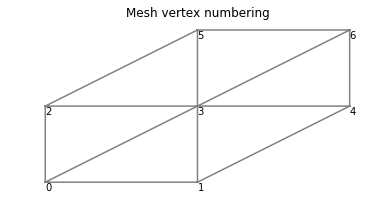

In [3]:
# Get the unit mesh
mesh = unit_mesh(1.0, 0.5)  # dx=1, dt=0.5, CFL safe
plot_mesh(mesh)

In [4]:
def plot_nodal_function(V, data):
    """Plot dof coordinates with data as labels."""
    dof_coors = V.tabulate_dof_coordinates().reshape((-1, 2))
    plot(V.mesh())
    plt.axis('off')
    for (i, d) in enumerate(data):
        plt.text(dof_coors[i][0], dof_coors[i][1], "{:0.4g}".format(d), verticalalignment="top")

Calling FFC just-in-time (JIT) compiler, this may take some time.


Text(0.5,1,'CG1 dof numbering')

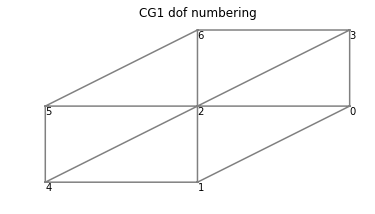

In [5]:
V = FunctionSpace(mesh, "CG", 1)
plot_nodal_function(V, list(range(7)))
plt.title("CG1 dof numbering")

In [6]:
def manual_assembly(V):
    """Generate basis and assemble the CG-CG a form.
    Args:
        V: Function space
    Outputs:
        u: 7 trial functions following the dof numbering
        v: 1 test function centered at the center node (#2)
        weights: weights[i]=a(u[i],v).
    """
    # v is centered at 2
    v = Function(V)
    v.vector()[2] = 1.0
    # u are trial functions
    u = []
    for i in range(7):
        t = Function(V)
        t.vector()[i] = 1.0
        u.append(t)
    # Bilinear form
    g = Constant(((-1.0, 0.0), (0.0, 1.0)))
    def a(u, v):
        return assemble(dot(grad(v), dot(g, grad(u))) * dx)
    # Compute weights
    weights = []
    for i in range(7):
        weights.append(a(u[i], v))
    return (u, v, weights)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Text(0.5,1,'Nodal weights')

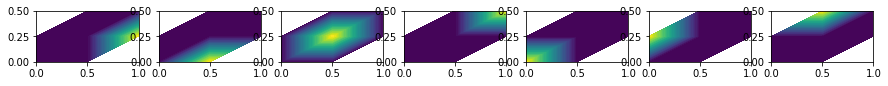

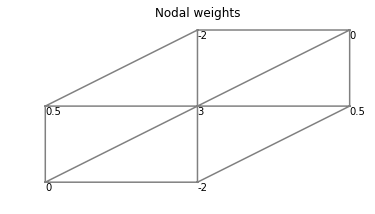

In [7]:
(u, v, weights) = manual_assembly(V)
# Plot trial functions u
plt.figure(figsize=(15, 3))
for i in range(7):
    plt.subplot(1, 7, i + 1)
    plot(u[i])
plt.figure()
plot_nodal_function(V, weights)
plt.title("Nodal weights")

In [8]:
def magnification_factor(weights):
    """von Neumann analysis of the magnification factor.
    """
    # u(m dt, n dx) ~ r^m*exp(i*n*theta)
    # Magnification factor r has to be tested for all thetas
    theta = np.linspace(0, np.pi * 2.0, 1000)
    # r satisfies a*r^2 + b*r + c = 0.
    a = weights[6] + weights[3] * np.exp(theta * 1j)
    b = weights[5] * np.exp(theta * -1j) + weights[2] + weights[0] * np.exp(theta * 1j)
    c = weights[4] * np.exp(theta * -1j) + weights[1]
    # Solve quadratic equation
    d = np.sqrt(b ** 2 - 4 * a * c)
    r1 = (-b + d) / (2.0 * a)
    r2 = (-b - d) / (2.0 * a)
    # Plot the 2 magnification factors as a function of theta
    # The curves should be inside or on the unit circle to be stable
    plt.plot(r1.real, r1.imag)
    plt.plot(r2.real, r2.imag)

Text(0,0.5,'Im(r)')

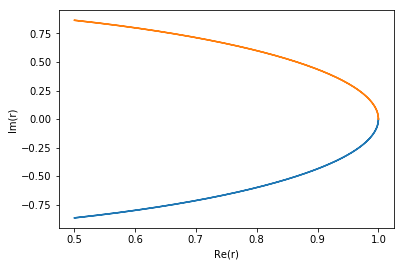

In [9]:
# Unperturbed case with dt/dx=0.5, everything is fine
magnification_factor(weights)
plt.xlabel("Re(r)")
plt.ylabel("Im(r)")

In [10]:
def analyze_mesh(mesh, prefix=None):
    """Previous steps put together."""
    V = FunctionSpace(mesh, "CG", 1)
    (_, _, weights) = manual_assembly(V)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plot_nodal_function(V, weights)
    plt.title("Nodal weights")
    plt.subplot(1, 2, 2)
    magnification_factor(weights)
    plt.title("Magnification factor")
    plt.xlabel("Re(r)")
    plt.ylabel("Im(r)")
    plt.tight_layout()
    plt.savefig("analysis_{}.svg".format(prefix), transparent=True, bbox_inches="tight", pad_inches=0)

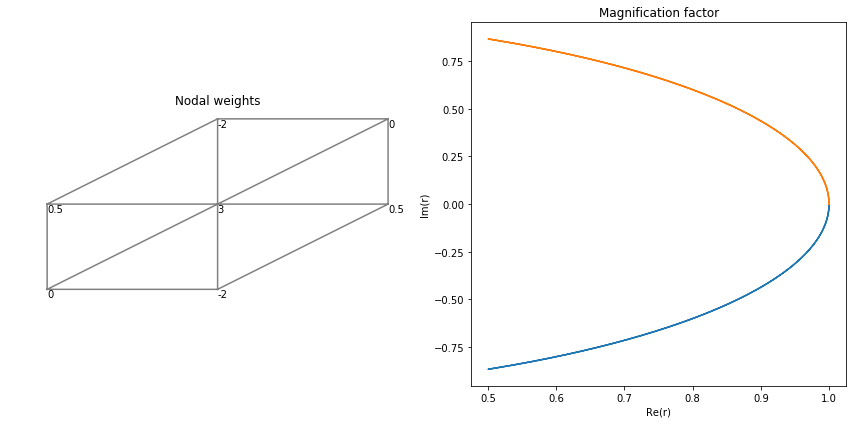

In [11]:
# Safe case before. dt/dx=0.5.
mesh = unit_mesh(1.0, 0.5)
analyze_mesh(mesh, "good")

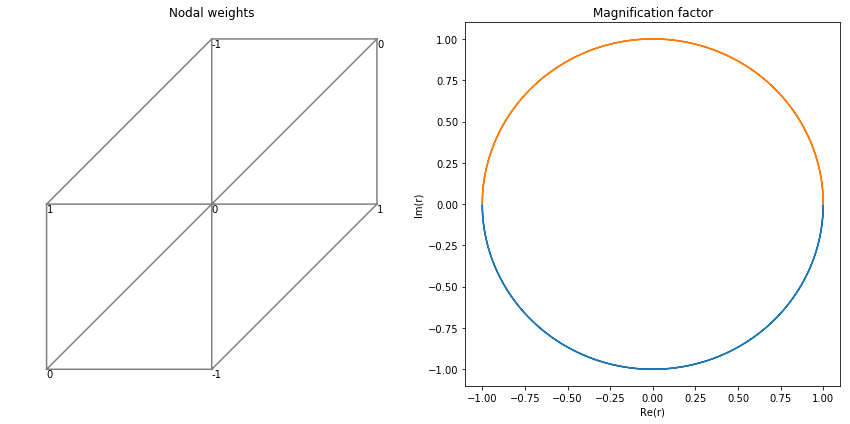

In [12]:
# Bordering case dt/dx=1.0. Magnification factor on the circle.
mesh = unit_mesh(1.0, 1.0)
analyze_mesh(mesh, "border")

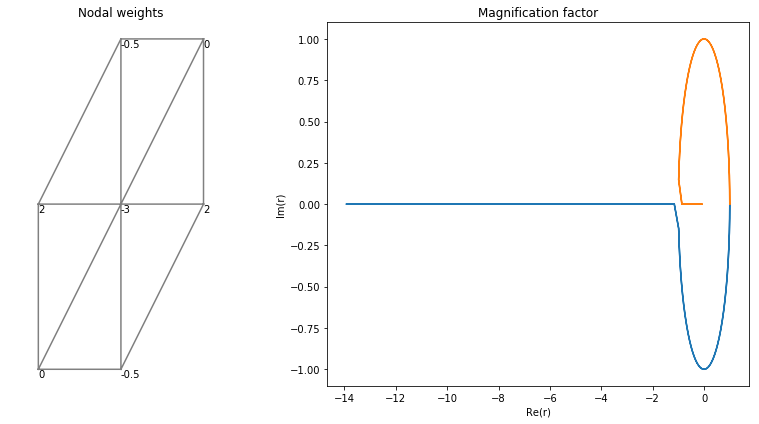

In [13]:
# Crank-Nicolson with bad CFL dt/dx=2.0. Clearly unstable.
mesh = unit_mesh(0.5, 1.0)
analyze_mesh(mesh, "bad")

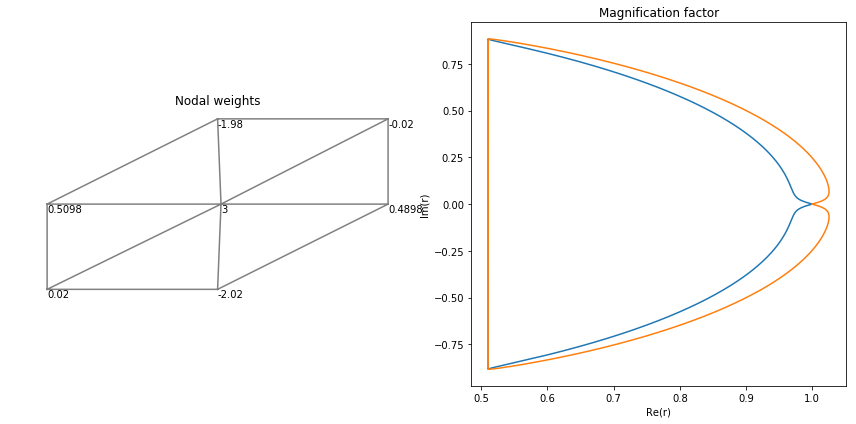

In [14]:
# Perturb the middle node slightly in the spatial direction for the safe dt/dx=0.5 case. Certainly unstable.
mesh = unit_mesh(1.0, 0.5)
mesh.coordinates()[3] += np.array([0.01, 0.0])
analyze_mesh(mesh, "mid")

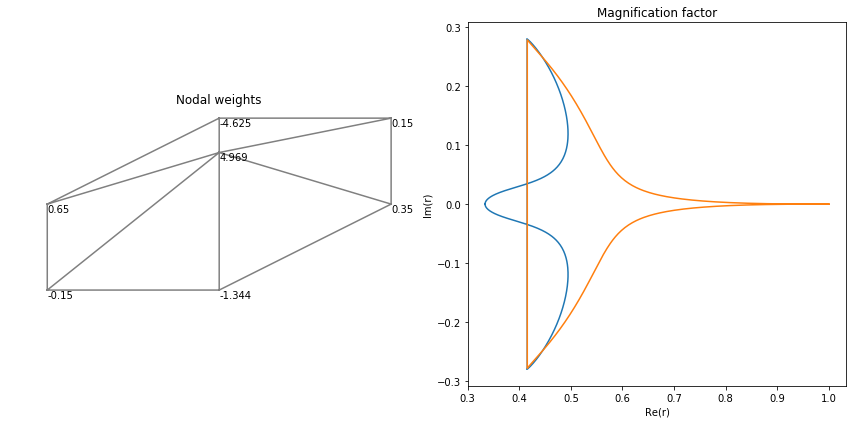

In [15]:
# Perturb the middle node quite a bit in the time direction for the safe dt/dx=0.5 case. Still good.
mesh = unit_mesh(1.0, 0.5)
mesh.coordinates()[3] += np.array([0.0, 0.15])
analyze_mesh(mesh, "temporal")

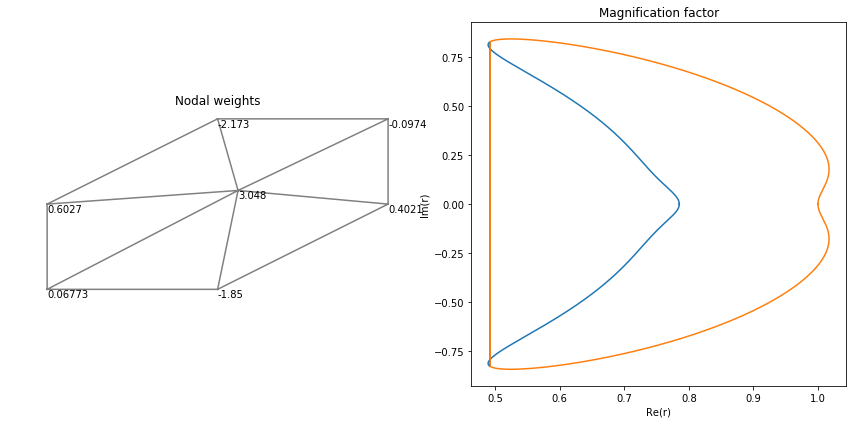

In [16]:
# Perturb the middle node generally for the safe dt/dx=0.5 case. 
# Unstable if delta_x > delta_t
mesh = unit_mesh(1.0, 0.5)
mesh.coordinates()[3] += np.array([0.06, 0.04])
analyze_mesh(mesh, "general")

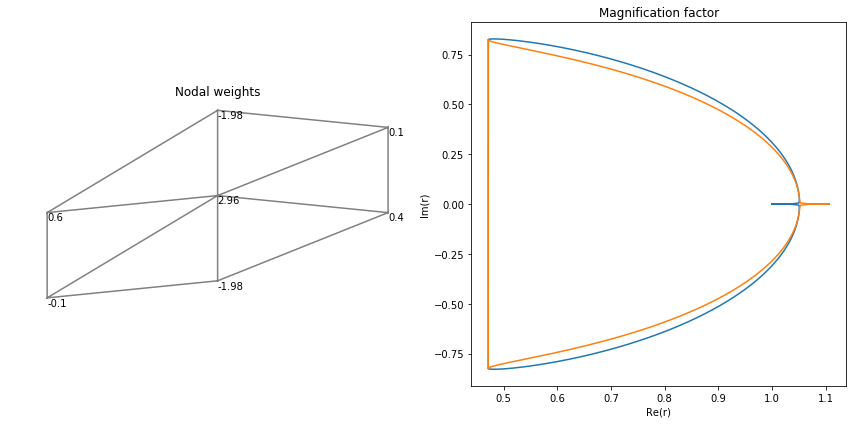

In [17]:
# Perturb all the middle node in the time direction for the safe dt/dx=0.5 case. Unstable.
# Note that only one mode is unstable in this case
mesh = unit_mesh(1.0, 0.5)
for i in [5, 3, 1]:
    mesh.coordinates()[i] += np.array([0.0, 0.05])
analyze_mesh(mesh, "all_t")

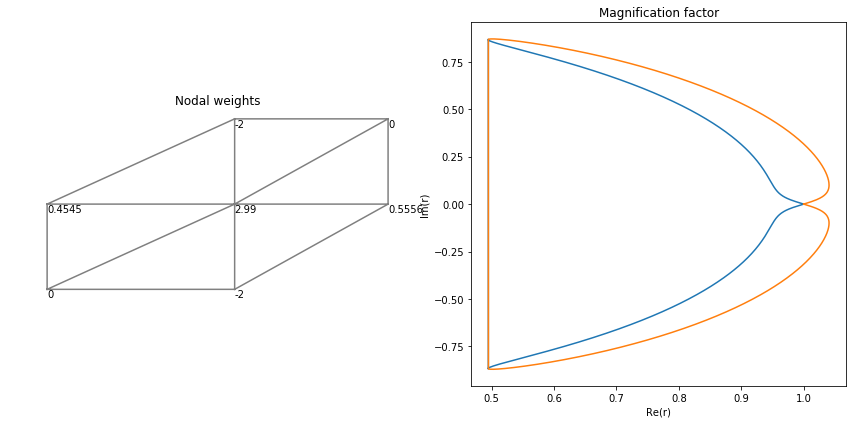

In [18]:
# Perturb all the middle node in the sptial direction for the safe dt/dx=0.5 case. Unstable.
# Note that it is unstable for quite some modes
mesh = unit_mesh(1.0, 0.5)
for i in [5, 3, 1]:
    mesh.coordinates()[i] += np.array([0.05, 0.00])
analyze_mesh(mesh, "all_s")

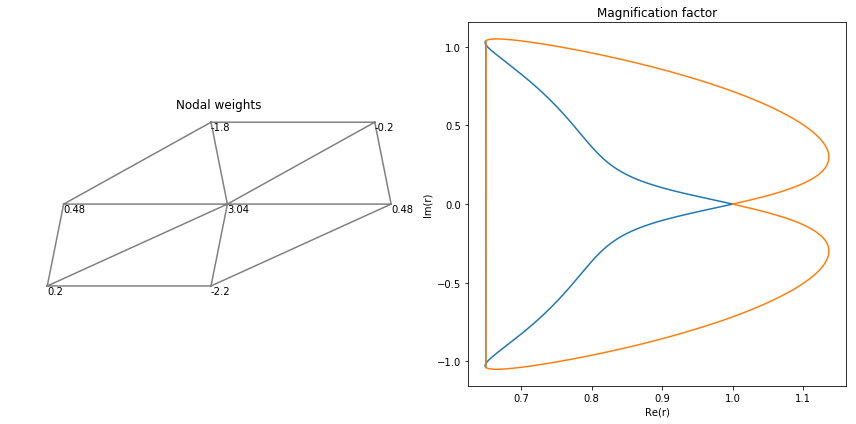

In [19]:
# Perturb all the middle node in the sptial direction for the safe dt/dx=0.5 case. Unstable.
# Note that it is unstable for quite some modes
mesh = unit_mesh(1.0, 0.5)
for i in [2, 3, 4]:
    mesh.coordinates()[i] += np.array([0.05, 0.00])
analyze_mesh(mesh, "slice")